In [2]:
!pip install fastai --upgrade
!pip install timm wwf

     |████████████████████████████████| 194kB 17.1MB/s 
     |████████████████████████████████| 61kB 10.7MB/s 
  Found existing installation: fastai 1.0.61
    Uninstalling fastai-1.0.61:
      Successfully uninstalled fastai-1.0.61
     |████████████████████████████████| 245kB 14.7MB/s 
  Created wheel for wwf: filename=wwf-0.0.10-cp36-none-any.whl size=23155 sha256=8716ec226c02c34e7ce6d07ca92d6104a8fa7312b041bcd1d211d041294189c6
  Stored in directory: /root/.cache/pip/wheels/c7/22/a7/30cb5077503f2c5d1c0af9187090604237d9e075154d833eb5
Successfully built wwf


In [3]:
!wget https://www.dropbox.com/s/cb3g53z4pbtaqvl/erm.zip?dl=1 -O erm.zip

--2021-02-05 09:17:32--  https://www.dropbox.com/s/cb3g53z4pbtaqvl/erm.zip?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.6.18, 2620:100:601c:18::a27d:612
Connecting to www.dropbox.com (www.dropbox.com)|162.125.6.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/dl/cb3g53z4pbtaqvl/erm.zip [following]
--2021-02-05 09:17:32--  https://www.dropbox.com/s/dl/cb3g53z4pbtaqvl/erm.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucb106c2a34ea5d21b841e09d9a6.dl.dropboxusercontent.com/cd/0/get/BIU0McE57Fpx5_yVrFDi02UrDP8cdQMILpqZvUGmZiyqKsiIlbjNIM2BNOBdIbGqmqQTRh_IZG2_s6qsxu3gcC7RVty-6bj78coJQRRaKbgS9t498gd3L-nbAXG2MKiYFow/file?dl=1# [following]
--2021-02-05 09:17:32--  https://ucb106c2a34ea5d21b841e09d9a6.dl.dropboxusercontent.com/cd/0/get/BIU0McE57Fpx5_yVrFDi02UrDP8cdQMILpqZvUGmZiyqKsiIlbjNIM2BNOBdIbGqmqQTRh_IZG2_s6qsxu3gcC7RVty-6bj78coJQRRaKbgS9t498gd3L-nbAXG2

In [4]:
!unzip erm.zip

Archive:  erm.zip
   creating: dataset/
   creating: dataset/test/
   creating: dataset/test/no/
  inflating: dataset/test/no/anonymized_1421704.jpg  
  inflating: dataset/test/no/anonymized_336537.jpg  
  inflating: dataset/test/no/anonymized_569526.jpg  
  inflating: dataset/test/no/anonymized_196860.jpg  
  inflating: dataset/test/no/anonymized_920184.jpg  
  inflating: dataset/test/no/anonymized_1348815.jpg  
  inflating: dataset/test/no/anonymized_225304.jpg  
  inflating: dataset/test/no/anonymized_816099.jpg  
  inflating: dataset/test/no/anonymized_260226.jpg  
  inflating: dataset/test/no/anonymized_1619231.jpg  
  inflating: dataset/test/no/anonymized_1314755.jpg  
  inflating: dataset/test/no/anonymized_1182585.jpg  
  inflating: dataset/test/no/anonymized_656024.jpg  
  inflating: dataset/test/no/anonymized_198917.jpg  
  inflating: dataset/test/no/anonymized_246204.jpg  
  inflating: dataset/test/no/anonymized_324557.jpg  
  inflating: dataset/test/no/anonymized_492637.jpg

In [5]:
from fastai.vision.all import *
import fastai
from wwf.vision.timm import *

In [6]:
path = Path('dataset/')
trainPath = path/'train'
testPath = path/'test'

In [7]:
def getDataBlock(presize=512,size=256):
    return DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=RandomSplitter(valid_pct=0.2,seed=42),
                 get_y=parent_label,
                 item_tfms = Resize(presize),
                 batch_tfms=[*aug_transforms(size=size, min_scale=0.75), Normalize.from_stats(*imagenet_stats)])

In [9]:
db512 = getDataBlock()
dls512 = db512.dataloaders(trainPath,bs=64)

In [10]:
from fastai.vision.all import *
callbacks = [
    ShowGraphCallback(),
    EarlyStoppingCallback(patience=3),
    SaveModelCallback(fname='resnest36')
]

In [12]:
import timm
timm.list_models('*resnest26*')

['resnest26d', 'resnest269e']

In [13]:
learn = timm_learner(dls512, 'resnest26d',cbs = callbacks,metrics=[accuracy,Precision(),Recall()]).to_fp16()

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/gluon_resnest26-50eb607c.pth" to /root/.cache/torch/hub/checkpoints/gluon_resnest26-50eb607c.pth


SuggestedLRs(lr_min=0.00020892962347716094, lr_steep=7.585775847473997e-07)

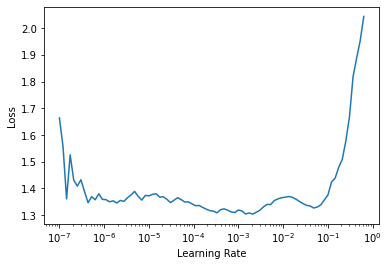

In [14]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,1.393076,0.867793,0.538226,0.530769,0.433962,00:29


Better model found at epoch 0 with valid_loss value: 0.8677933812141418.


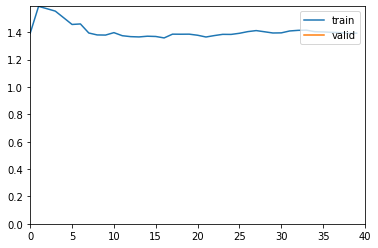

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,1.370317,0.870646,0.521407,0.509091,0.440252,00:35
1,1.345039,0.872170,0.518349,0.505415,0.440252,00:33
2,1.304709,0.852990,0.539755,0.526316,0.534591,00:33
3,1.305606,0.842469,0.538226,0.525478,0.518868,00:33
4,1.237535,0.841456,0.550459,0.536810,0.550314,00:33
5,1.268564,0.846146,0.547401,0.534375,0.537736,00:33
6,1.280050,0.847310,0.541284,0.528125,0.531447,00:33
7,1.277668,0.844711,0.545872,0.530973,0.566038,00:33


Better model found at epoch 0 with valid_loss value: 0.870646059513092.


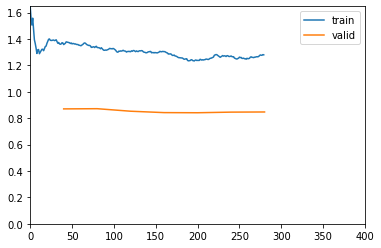

Better model found at epoch 2 with valid_loss value: 0.8529902100563049.
Better model found at epoch 3 with valid_loss value: 0.8424692153930664.
Better model found at epoch 4 with valid_loss value: 0.8414555788040161.
No improvement since epoch 4: early stopping


In [15]:
learn.fine_tune(10,base_lr=1e-5)

In [16]:
dbTest = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=GrandparentSplitter(valid_name='test'),
                 get_y=parent_label,
                 item_tfms = Resize(512),
                 batch_tfms=[*aug_transforms(size=256, min_scale=0.75), Normalize.from_stats(*imagenet_stats)])
dlsTest = dbTest.dataloaders(path,bs=32)

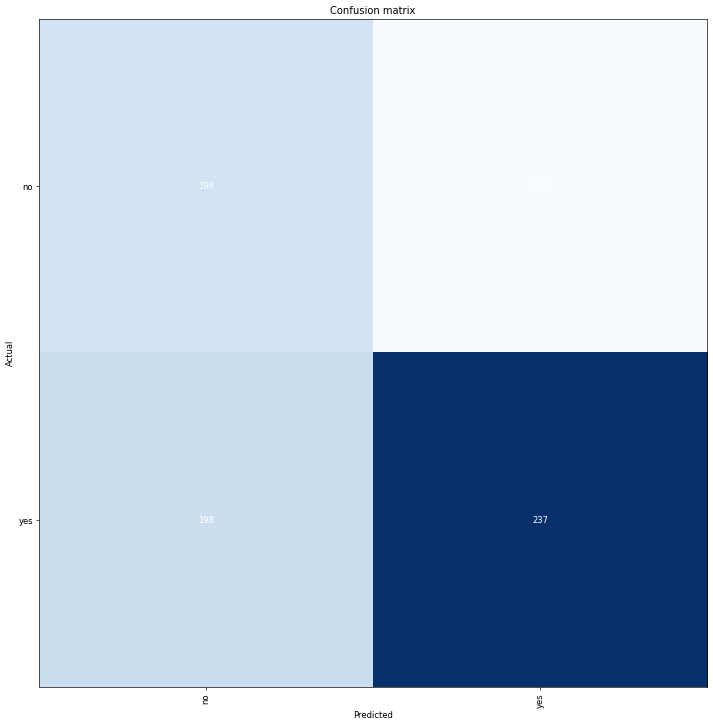

In [17]:
learn.dls = dlsTest
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(12,12),dpi=60)

In [18]:
learn.validate()

Better model found at epoch 0 with valid_loss value: 0.5293398499488831.


(#4) [0.8962011933326721,0.5293398499488831,0.5589622641509434,0.5448275862068965]

In [19]:
learn.export(fname='resnet50.pkl')